In [1]:
import openbabel

In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

In [23]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v5
from IPython.display import HTML

# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    :params: verbose - parameters for gradient boosting models
    :params: early_stopping_rounds - parameters for gradient boosting models
    :params: n_estimators - parameters for gradient boosting models
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    :params: verbose - parameters for gradient boosting models
    :params: early_stopping_rounds - parameters for gradient boosting models
    :params: n_estimators - parameters for gradient boosting models
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

In [24]:
# from https://www.kaggle.com/artgor/artgor-utils
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [25]:
path = r'C:\Users\tag\Desktop\Project\myProjects\062019_Kg_Atom'
train = pd.read_csv(path + '/train.csv')
test = pd.read_csv(path + '/test.csv')
sub = pd.read_csv(path +'/sample_submission.csv')
structures = pd.read_csv(path + '/structures.csv')
scalar_coupling_contributions = pd.read_csv(path + '/scalar_coupling_contributions.csv')

In [26]:
print('Train dataset shape is -> rows: {} cols:{}'.format(train.shape[0],train.shape[1]))
print('Test dataset shape is  -> rows: {} cols:{}'.format(test.shape[0],test.shape[1]))
print('Sub dataset shape is  -> rows: {} cols:{}'.format(sub.shape[0],sub.shape[1]))
print('Structures dataset shape is  -> rows: {} cols:{}'.format(structures.shape[0],structures.shape[1]))
print('Scalar_coupling_contributions dataset shape is  -> rows: {} cols:{}'.format(scalar_coupling_contributions.shape[0],
                                                                                   scalar_coupling_contributions.shape[1]))

Train dataset shape is -> rows: 4658147 cols:6
Test dataset shape is  -> rows: 2505542 cols:5
Sub dataset shape is  -> rows: 2505542 cols:2
Structures dataset shape is  -> rows: 2358657 cols:6
Scalar_coupling_contributions dataset shape is  -> rows: 4658147 cols:8


In [8]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001


In [9]:
train = pd.merge(train, scalar_coupling_contributions, how='left',
                left_on = ['molecule_name', 'atom_index_0', 'atom_index_1'],
                right_on = ['molecule_name', 'atom_index_0', 'atom_index_1'])

In [27]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001


In [28]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [29]:
scalar_coupling_contributions.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.022400000000005,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.034700000000001,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.032500000000001,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.031900000000000,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.022199999999998,0.254585,1.25861,0.272013


In [30]:
pd.concat([scalar_coupling_contributions['fc'], train['scalar_coupling_constant']], axis=1)[:10]

,fc,scalar_coupling_constant
0,83.022400000000005,84.807599999999994
1,-11.034700000000001,-11.257000000000000
2,-11.032500000000001,-11.254799999999999
3,-11.031900000000000,-11.254300000000001
4,83.022199999999998,84.807400000000001
5,-11.031700000000001,-11.254099999999999
6,-11.032400000000001,-11.254799999999999
7,83.024100000000004,84.809299999999993
8,-11.031900000000000,-11.254300000000001
9,83.024299999999997,84.809500000000000


In [31]:
from tqdm import tqdm_notebook as tqdm
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

display(structures.head())

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


,molecule_name,atom_index,atom,x,y,z,EN,rad
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958,2.55,0.82
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204,2.20,0.43
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748,2.20,0.43
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152,2.20,0.43
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942,2.20,0.43


In [32]:
structures[['x','y','z']].values

array([[-1.26981359e-02,  1.08580416e+00,  8.00099580e-03],
       [ 2.15041600e-03, -6.03131760e-03,  1.97612040e-03],
       [ 1.01173084e+00,  1.46375116e+00,  2.76574800e-04],
       ...,
       [ 2.51585406e+00, -1.15178377e+00,  5.27369256e-01],
       [ 1.36988019e-02,  1.19943057e+00, -1.68019230e+00],
       [ 1.26074533e+00, -1.24675365e+00, -1.90676716e+00]])

In [33]:
structures.head()

,molecule_name,atom_index,atom,x,y,z,EN,rad
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958,2.55,0.82
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204,2.20,0.43
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748,2.20,0.43
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152,2.20,0.43
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942,2.20,0.43


In [34]:
structures['molecule_name'].values

array(['dsgdb9nsd_000001', 'dsgdb9nsd_000001', 'dsgdb9nsd_000001', ...,
       'dsgdb9nsd_133885', 'dsgdb9nsd_133885', 'dsgdb9nsd_133885'],
      dtype=object)

In [35]:
i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating the bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

#bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
#bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))

Calculating the bonds



Counting and condensing bonds


,molecule_name,atom_index,atom,x,y,z,EN,rad,n_bonds,bond_lengths_mean
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958,2.55,0.82,4,1.091949701309204
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204,2.20,0.43,1,1.091953039169312
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748,2.20,0.43,1,1.091951608657837
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152,2.20,0.43,1,1.091946363449097
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942,2.20,0.43,1,1.091947555541992
5,dsgdb9nsd_000002,0,N,-0.0404260543,1.0241077530,0.0625637998,3.04,0.80,3,1.017194986343384
6,dsgdb9nsd_000002,1,H,0.0172574639,0.0125452063,-0.0273771593,2.20,0.43,1,1.017189979553223
7,dsgdb9nsd_000002,2,H,0.9157893661,1.3587451950,-0.0287577581,2.20,0.43,1,1.017187237739563
8,dsgdb9nsd_000002,3,H,-0.5202777357,1.3435321260,-0.7755426124,2.20,0.43,1,1.017207860946655
9,dsgdb9nsd_000003,0,O,-0.0343604951,0.9775395708,0.0076015923,3.44,0.78,2,0.962106823921204


In [36]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

atom_count=structures.groupby(['molecule_name','atom']).size().unstack(fill_value=0)
train=pd.merge(train,atom_count, how = 'left', left_on  = 'molecule_name', right_on = 'molecule_name')
test=pd.merge(test,atom_count, how = 'left', left_on  = 'molecule_name', right_on = 'molecule_name')

In [37]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,C,F,H,N,O
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,...,0.0080009958,2.55,0.82,4,1.091949701309204,1,0,4,0,0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,...,0.0002765748,2.20,0.43,1,1.091951608657837,1,0,4,0,0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,...,-0.8766437152,2.20,0.43,1,1.091946363449097,1,0,4,0,0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,...,0.9063972942,2.20,0.43,1,1.091947555541992,1,0,4,0,0
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,...,0.0080009958,2.55,0.82,4,1.091949701309204,1,0,4,0,0


In [42]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942


In [38]:

obConversion = openbabel.OBConversion()
obConversion.SetInFormat("xyz")

structdir=path+'/structures/'
mols=[]
mols_files=os.listdir(structdir)
mols_index=dict(map(reversed,enumerate(mols_files)))
for f in mols_index.keys():
    mol = openbabel.OBMol()
    obConversion.ReadFile(mol, structdir+f) 
    mols.append(mol)

In [39]:
def Atoms(molname, AtomId1, AtomId2):
    mol=mols[mols_index[molname+'.xyz']]
    return mol, mol.GetAtomById(AtomId1), mol.GetAtomById(AtomId2)

def SecondAtom(bond, FirstAtom):
    if FirstAtom.GetId()==bond.GetBeginAtom().GetId(): return bond.GetEndAtom()
    else: return bond.GetBeginAtom()

def Angle2J(molname,AtomId1,AtomId2,debug=False):
    mol, firstAtom, lastAtom = Atoms(molname, AtomId1, AtomId2)
    if debug: print (mol.GetFormula())
    if debug: print(firstAtom.GetType(), firstAtom.GetId(),':',lastAtom.GetType(), lastAtom.GetId())
    for b in openbabel.OBAtomBondIter(firstAtom): # all bonds for first atom
        secondAtom=SecondAtom(b,firstAtom)
        lastBond=secondAtom.GetBond(lastAtom)
        if lastBond: # found!
            if debug: print('middle',secondAtom.GetId(),secondAtom.GetType())
        return firstAtom.GetAngle(secondAtom,lastAtom)

Angle2J('dsgdb9nsd_000003',1,2,debug=True) #water

H2O
HO 1 : HO 2
middle 0 O3


103.71576124592411

In [40]:
def Torsion3J(molname,AtomId1,AtomId2,debug=False):
    mol,firstAtom,lastAtom=Atoms(molname,AtomId1,AtomId2)
    if debug: print (molname, mol.GetFormula())
    if debug: print(firstAtom.GetType(),firstAtom.GetId(),':',lastAtom.GetType(),lastAtom.GetId())
    for b in openbabel.OBAtomBondIter(firstAtom): # all bonds for first atom
      secondAtom=SecondAtom(b,firstAtom)
      for b2 in openbabel.OBAtomBondIter(secondAtom): # all bonds for second atom 
        thirdAtom=SecondAtom(b2,secondAtom)
        lastBond=thirdAtom.GetBond(lastAtom)
        if lastBond: # found!
          if debug: print(secondAtom.GetType(),secondAtom.GetId(),'<->',thirdAtom.GetType(),thirdAtom.GetId())
          return mol.GetTorsion(firstAtom,secondAtom,thirdAtom,lastAtom)
          
Torsion3J('dsgdb9nsd_000007',2,5,debug=True) #methanol

dsgdb9nsd_000007 C2H6
H 2 : H 5
C3 0 <-> C3 1


60.00280550635594

In [41]:
train['bonds']=train['type'].str[0].astype(int)
test['bonds']=test['type'].str[0].astype(int)

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['abs_dist']=np.linalg.norm(train_p_0-train_p_1,axis=1,ord=1)
test['abs_dist']=np.linalg.norm(test_p_0-test_p_1,axis=1,ord=1)

In [42]:
def dist12(name='xy',a='x',b='y'):
    train_p_0=train[[a+'_0',b+'_0']].values
    train_p_1=train[[a+'_1',b+'_1']].values
    test_p_0=test[[a+'_0',b+'_0']].values
    test_p_1=test[[a+'_1',b+'_1']].values
    
    train[name] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
    test[name] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
    train['abs_'+name]= np.linalg.norm(train_p_0-train_p_1,axis=1,ord=1)
    test['abs_'+name]= np.linalg.norm(test_p_0-test_p_1,axis=1,ord=1)

In [43]:
dist12('dist_xy','x','y')
dist12('dist_xz','x','z')
dist12('dist_yz','y','z')

In [44]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,O,bonds,dist,abs_dist,dist_xy,abs_dist_xy,dist_xz,abs_dist_xz,dist_yz,abs_dist_yz
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,...,0,1,1.091953059611900,1.1127089029,1.091936438293093,1.1066840275,0.016024313311731,0.0208734273,1.091852098455768,1.0978603510
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,...,0,2,1.783119756038801,2.4810624522,1.783118946094350,2.4793629066,1.009581857521592,1.0112799726,1.469783462212843,1.4714820252
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,...,0,2,1.783147496403011,2.8751432522,1.551657880596930,1.9965234166,1.032852522585415,1.4215853206,1.698470922926572,2.3321777672
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,...,0,2,1.783156685329616,2.8743491859,1.536772626258658,1.9699280121,1.046238902945277,1.4303852243,1.703822051159491,2.3483851354
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,...,0,1,1.091951618581363,1.4101004039,1.091924297120763,1.4023759829,1.024458100407177,1.0321533999,0.378025931005217,0.3856714250


In [45]:
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

train['dist_to_type_std'] = train['dist'] / train.groupby('type')['dist'].transform('std')
test['dist_to_type_std'] = test['dist'] / test.groupby('type')['dist'].transform('std')

train['dist_to_type_mean_xy'] = train['dist_xy'] / train.groupby('type')['dist_xy'].transform('mean')
test['dist_to_type_mean_xy'] = test['dist_xy'] / test.groupby('type')['dist_xy'].transform('mean')

train['dist_to_type_mean_xz'] = train['dist_xz'] / train.groupby('type')['dist_xz'].transform('mean')
test['dist_to_type_mean_xz'] = test['dist_xz'] / test.groupby('type')['dist_xz'].transform('mean')

train['dist_to_type_mean_yz'] = train['dist_yz'] / train.groupby('type')['dist_yz'].transform('mean')
test['dist_to_type_mean_yz'] = test['dist_yz'] / test.groupby('type')['dist_yz'].transform('mean')

In [46]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,abs_dist_xy,dist_xz,abs_dist_xz,dist_yz,abs_dist_yz,dist_to_type_mean,dist_to_type_std,dist_to_type_mean_xy,dist_to_type_mean_xz,dist_to_type_mean_yz
0,0,dsgdb9nsd_000001,1,0,1JHC,84.807599999999994,H,0.002150416,-0.0060313176,0.0019761204,...,1.1066840275,0.016024313311731,0.0208734273,1.091852098455768,1.0978603510,0.999133993514757,160.140258468183134,1.308822885399792,0.017808845798591,1.298372056998296
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257000000000000,H,0.002150416,-0.0060313176,0.0019761204,...,2.4793629066,1.009581857521592,1.0112799726,1.469783462212843,1.4714820252,1.004633785679569,76.528200864254643,1.420898540772882,0.653242996633718,1.119381740886271
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.254799999999999,H,0.002150416,-0.0060313176,0.0019761204,...,1.9965234166,1.032852522585415,1.4215853206,1.698470922926572,2.3321777672,1.004649414975929,76.529391429362306,1.236456167519326,0.668300120399065,1.293549279488992
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.254300000000001,H,0.002150416,-0.0060313176,0.0019761204,...,1.9699280121,1.046238902945277,1.4303852243,1.703822051159491,2.3483851354,1.004654592141451,76.529785801091180,1.224594683901192,0.676961685734461,1.297624679295201
4,4,dsgdb9nsd_000001,2,0,1JHC,84.807400000000001,H,1.011730843,1.4637511620,0.0002765748,...,1.4023759829,1.024458100407177,1.0321533999,0.378025931005217,0.3856714250,0.999132674975848,160.140047134004675,1.308808332680748,1.138545907231645,0.449528197392408


In [47]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_bonds_dist_std'] = df.groupby(['molecule_name', 'bonds'])['dist'].transform('std')
    df[f'molecule_bonds_dist_std_diff'] = df[f'molecule_bonds_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']

    return df

In [48]:
train = create_features(train)
test = create_features(test)

train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Mem. usage decreased to 959.55 Mb (71.4% reduction)
Mem. usage decreased to 501.79 Mb (71.9% reduction)


In [51]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,...,molecule_atom_1_dist_std_diff,molecule_bonds_dist_std,molecule_bonds_dist_std_diff,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_dist_std,molecule_type_dist_std_diff
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8125000,H,0.00214958190918,-0.006031036376953,0.001976013183594,...,-1.091796875,0.000003218650818,-1.091796875,1.091796875,-0.000003397464752,1.0,1.091796875,1.091796875,0.000003218650818,-1.091796875
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2578125,H,0.00214958190918,-0.006031036376953,0.001976013183594,...,-1.783203125,0.000013768672943,-1.783203125,1.783203125,0.000026583671570,1.0,1.783203125,1.783203125,0.000013768672943,-1.783203125
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2578125,H,0.00214958190918,-0.006031036376953,0.001976013183594,...,-1.783203125,0.000013768672943,-1.783203125,1.783203125,-0.000001192092896,1.0,1.783203125,1.783203125,0.000013768672943,-1.783203125
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2578125,H,0.00214958190918,-0.006031036376953,0.001976013183594,...,-1.783203125,0.000013768672943,-1.783203125,1.783203125,-0.000010371208191,1.0,1.783203125,1.783203125,0.000013768672943,-1.783203125
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8125000,H,1.01171875000000,1.463867187500000,0.000276565551758,...,-1.091796875,0.000003218650818,-1.091796875,1.091796875,-0.000001966953278,1.0,1.091796875,1.091796875,0.000003218650818,-1.091796875


In [52]:
# memory usage
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

                         train:   1.9GiB
                          test:   1.0GiB
 scalar_coupling_contributions: 808.5MiB
                    structures: 447.6MiB
                    bond_dists: 251.9MiB
                         bonds:  63.0MiB
                     p_compare:  54.0MiB
                           sub:  38.2MiB
                       bond_df:  36.0MiB
                      atoms_en:  18.9MiB


In [53]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

In [54]:
def group_mean_log_mae(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [55]:
for f in [ 'atom_0', 'atom_1']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) )
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [57]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    print(X.shape,X_test.shape)
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
      
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 3000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=500, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_absolute_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction, model

In [58]:
params = {
          'num_leaves': 128,
          'min_child_samples': 50,
          'objective': 'regression',
          'max_depth': 9,
          'learning_rate': 0.15,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 1.0,
          'device' : 'cpu',
          'gpu_platform_id' : 0,
          'gpu_device_id' : 0,
          'gpu_use_dp': False
         }

Training of type 1JHC
Predicting J= 1
(709416, 90) (380609, 90)
Fold 0 started at Fri Jun 21 14:35:49 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.31048	valid_1's l1: 1.5362
[1000]	training's l1: 1.0513	valid_1's l1: 1.41926
[1500]	training's l1: 0.887089	valid_1's l1: 1.36514
[2000]	training's l1: 0.765651	valid_1's l1: 1.33445
[2500]	training's l1: 0.668588	valid_1's l1: 1.31371
[3000]	training's l1: 0.588836	valid_1's l1: 1.2984
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.588836	valid_1's l1: 1.2984
Fold 1 started at Fri Jun 21 14:40:31 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.31464	valid_1's l1: 1.54838
[1000]	training's l1: 1.05292	valid_1's l1: 1.42913
[1500]	training's l1: 0.888642	valid_1's l1: 1.37416
[2000]	training's l1: 0.765574	valid_1's l1: 1.34157
[2500]	training's l1: 0.669352	valid_1's l1: 1.32122
[3000]	training's l1: 0.58896	valid_1's l1: 1.3053

[3000]	training's l1: 0.0046939	valid_1's l1: 0.543871
CV mean score: 0.5447, std: 0.0087.
Training of type 2JHN
Predicting J= 2
(119253, 90) (64424, 90)
Fold 0 started at Fri Jun 21 15:26:44 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.164819	valid_1's l1: 0.334292
[1000]	training's l1: 0.0905772	valid_1's l1: 0.321218
[1500]	training's l1: 0.053568	valid_1's l1: 0.316699
[2000]	training's l1: 0.032931	valid_1's l1: 0.314783
[2500]	training's l1: 0.0210732	valid_1's l1: 0.313877
[3000]	training's l1: 0.013993	valid_1's l1: 0.313406
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.013993	valid_1's l1: 0.313406
Fold 1 started at Fri Jun 21 15:29:47 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.168469	valid_1's l1: 0.340395
[1000]	training's l1: 0.0922344	valid_1's l1: 0.325483
[1500]	training's l1: 0.0547307	valid_1's l1: 0.320191
[2000]	training's l1: 0.03382	valid_1's l1: 

[3000]	training's l1: 0.106964	valid_1's l1: 0.276896
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.106964	valid_1's l1: 0.276896
CV mean score: 0.2780, std: 0.0007.
Training of type 3JHC
Predicting J= 3
(1510379, 92) (811999, 92)
Fold 0 started at Fri Jun 21 16:16:38 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.591677	valid_1's l1: 0.643326
[1000]	training's l1: 0.500495	valid_1's l1: 0.587195
[1500]	training's l1: 0.442263	valid_1's l1: 0.557394
[2000]	training's l1: 0.398415	valid_1's l1: 0.538134
[2500]	training's l1: 0.363345	valid_1's l1: 0.524941
[3000]	training's l1: 0.334172	valid_1's l1: 0.514829
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.334172	valid_1's l1: 0.514829
Fold 1 started at Fri Jun 21 16:20:56 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.590319	valid_1's l1: 0.643701
[1000]	training's l1: 0.499727	valid_1's l1: 0.587987

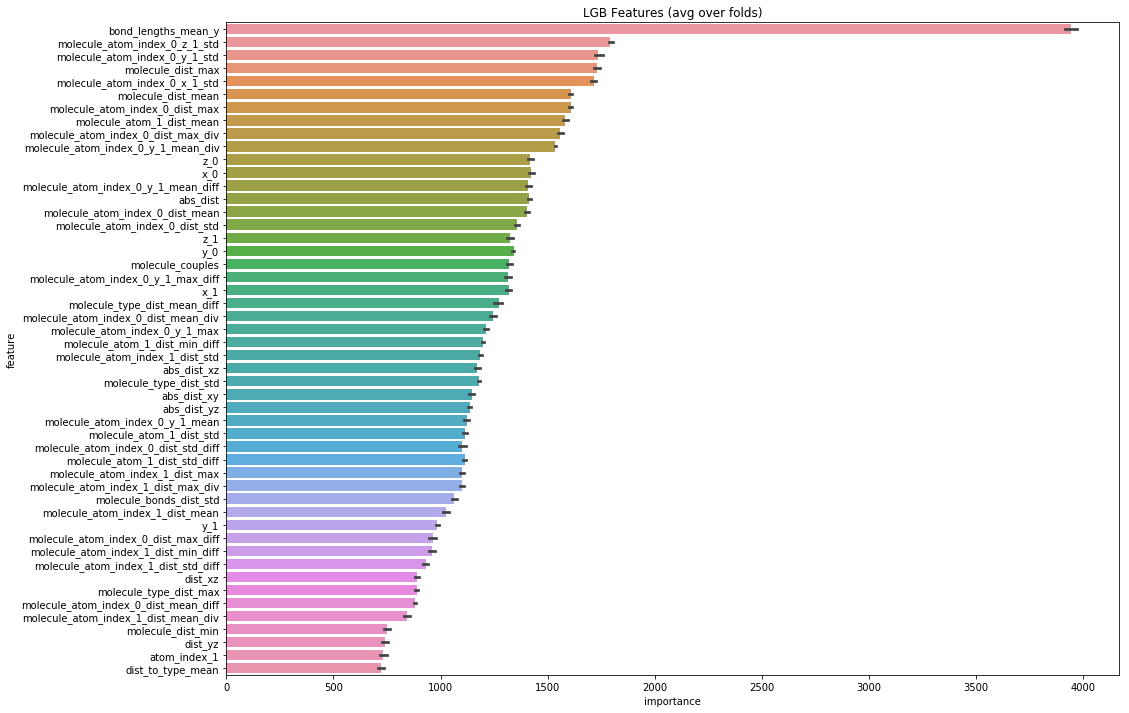

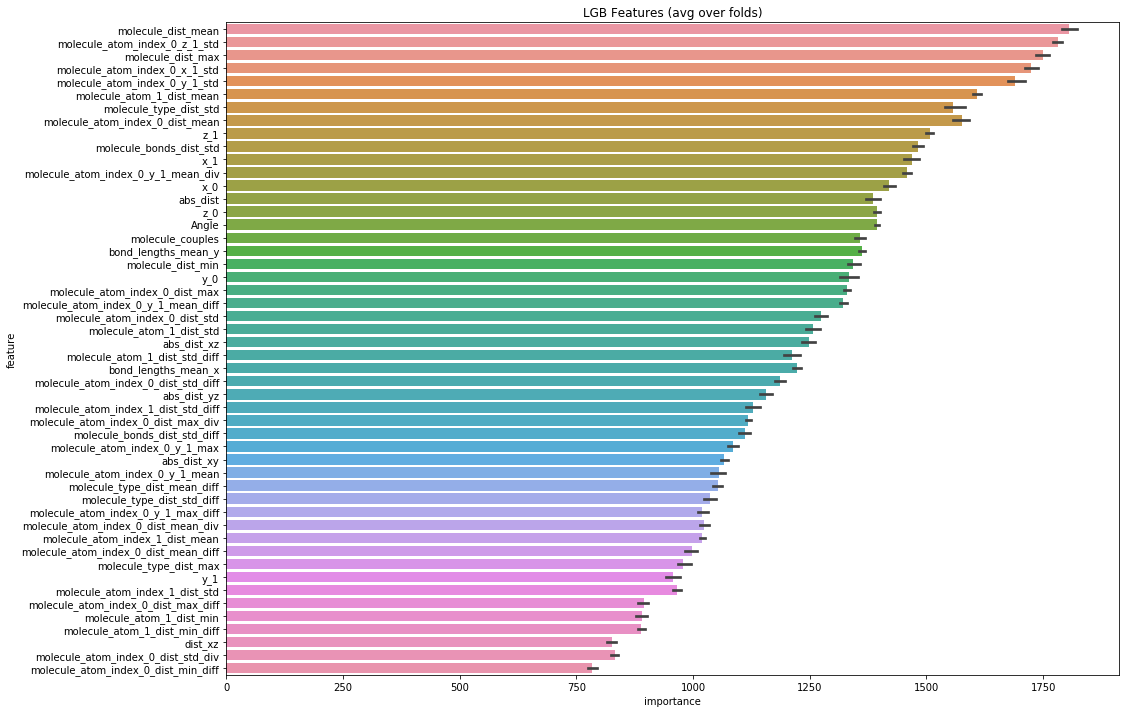

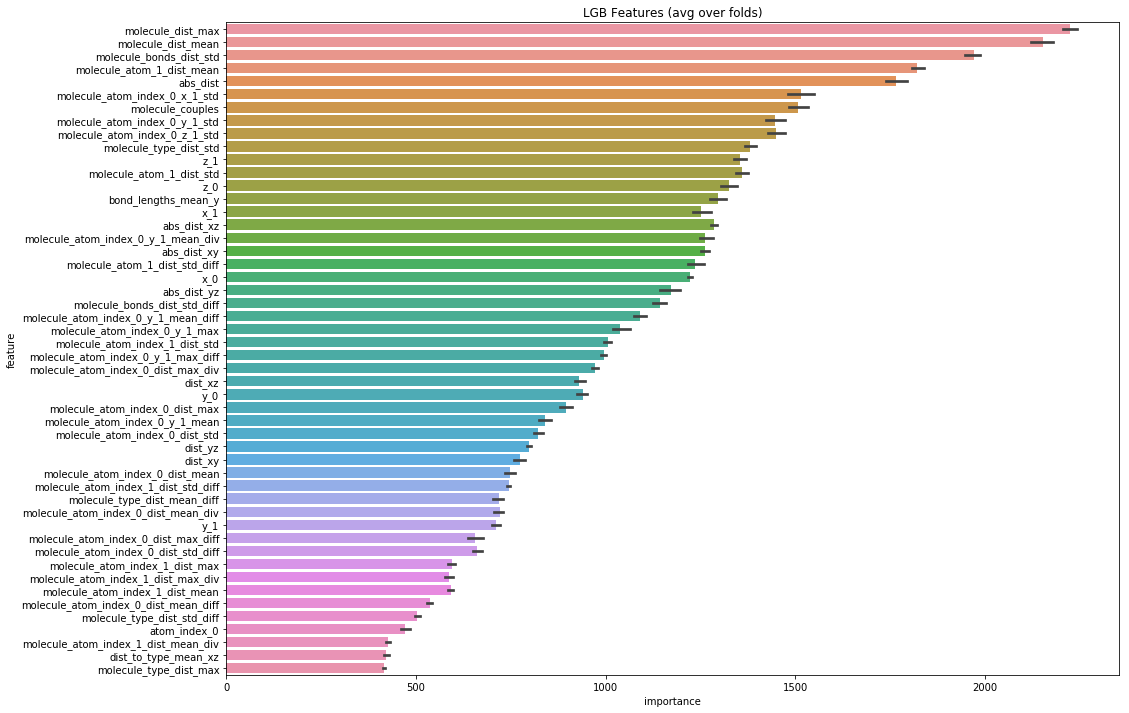

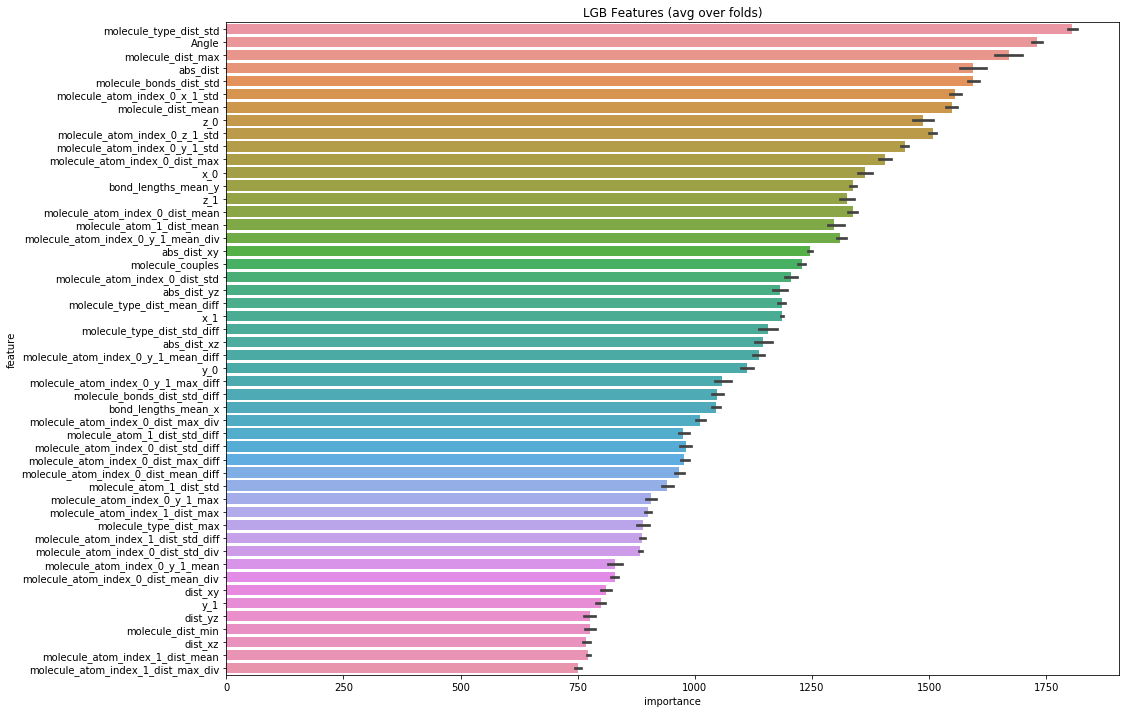

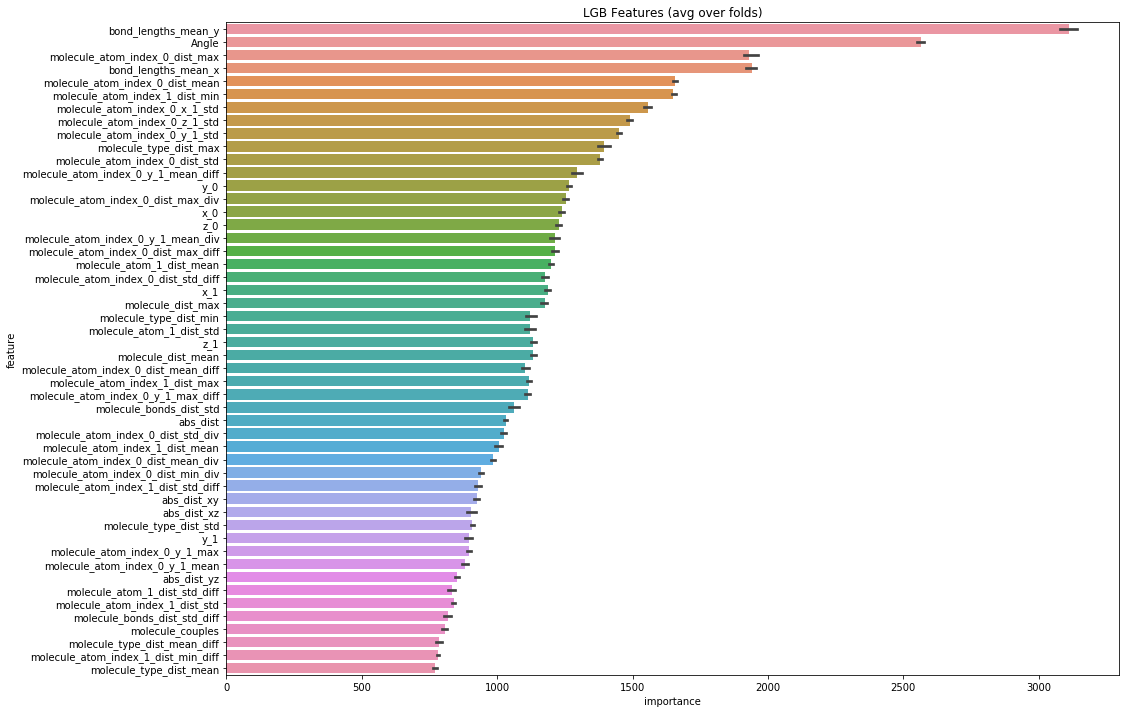

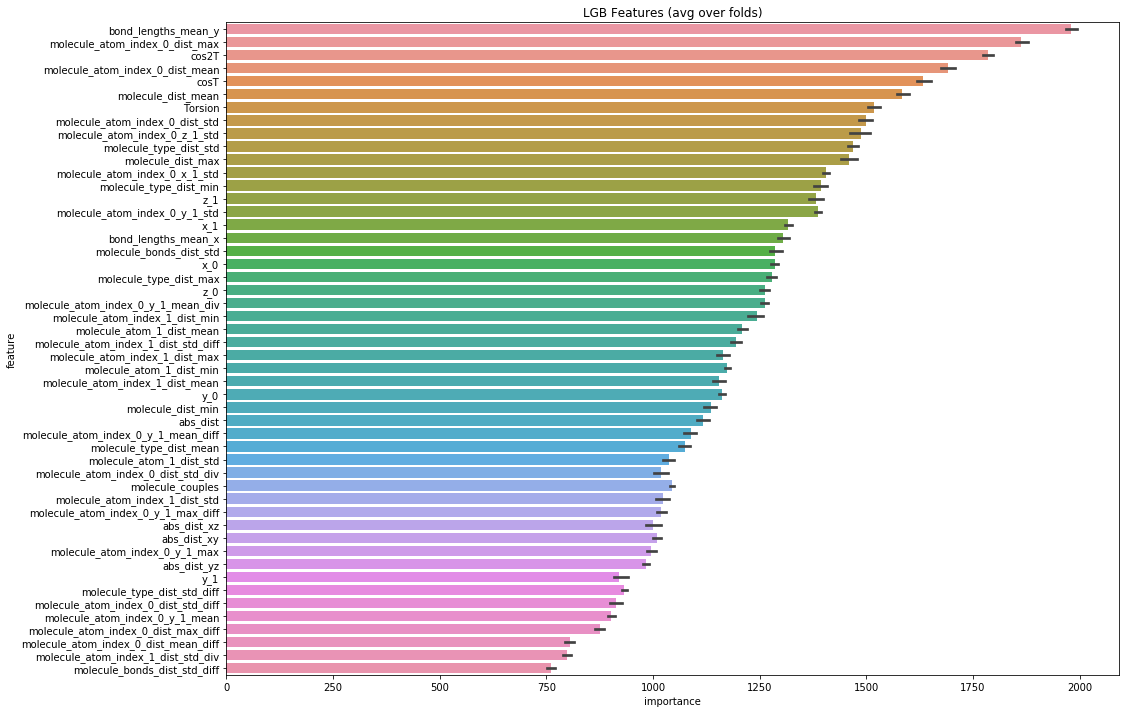

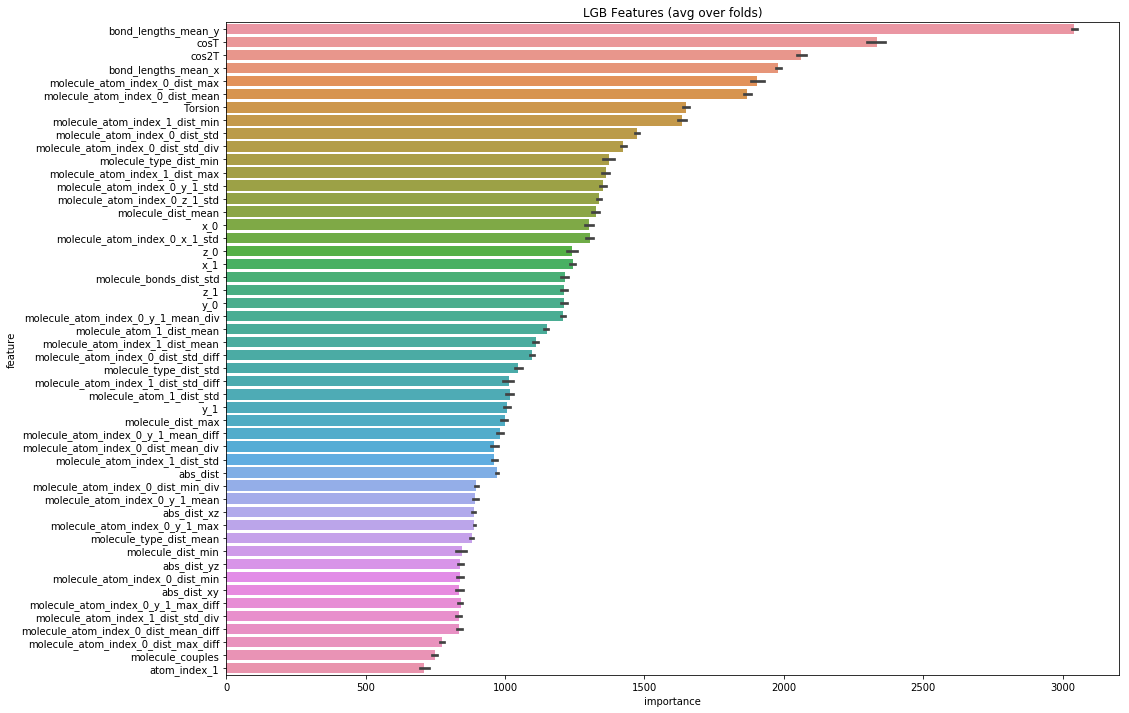

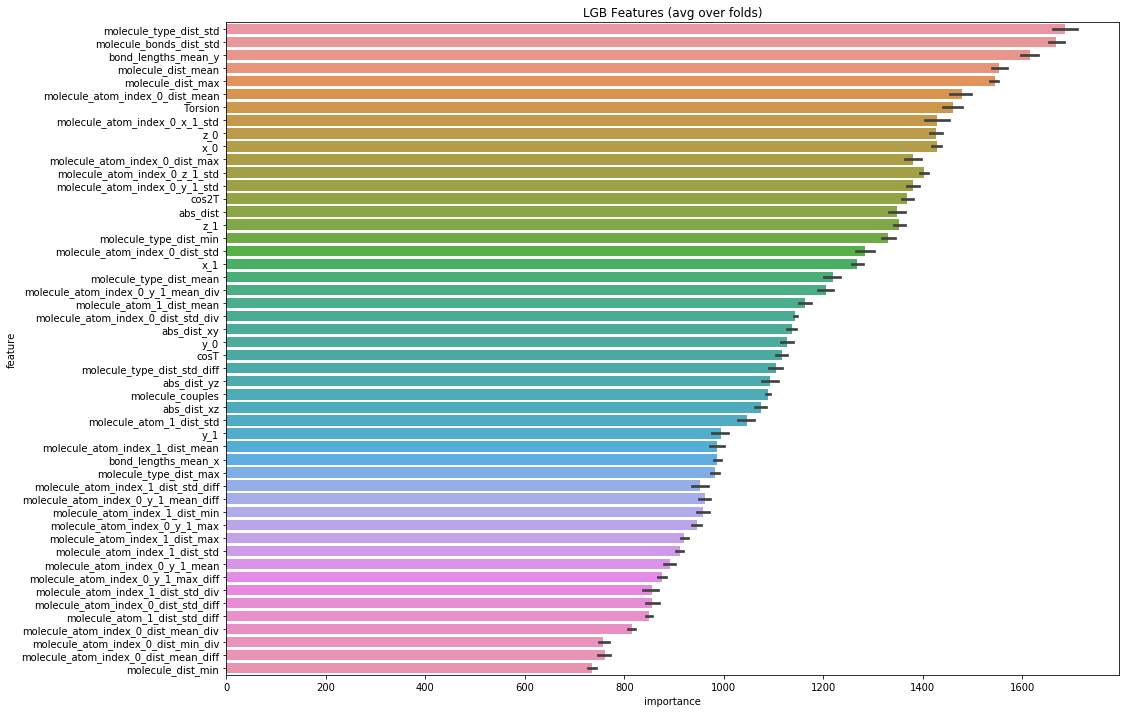

In [59]:
prediction_lgb=pd.DataFrame(test.shape[0],index=test['id'],columns=['scalar_coupling_constant'],dtype=float)
oof_lgb=pd.DataFrame(train.shape[0],index=train['id'],columns=['oof'],dtype=float)

for t in train['type'].unique():
    print(f'Training of type {t}')
    b=int(t[0]) # current bond for this type
    print('Predicting J=',b)
    X=train[train.type==t]
    if (b==1):
        X['sp']=X.apply(lambda row: Atoms(row.molecule_name, row.atom_index_0, row.atom_index_1)[2].GetHyb(),axis=1) # second atom is C or N for bond 1
    if (b==2):
        X['Angle']=X.apply(lambda row: Angle2J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
    if (b==3):
        X['Torsion']=X.apply(lambda row: Torsion3J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
        X['cosT']=np.cos(np.deg2rad(X['Torsion']))
        X['cos2T']=np.cos(2*np.deg2rad(X['Torsion']))
    y = X['scalar_coupling_constant']
    ids_train=X['id']
    X = X.drop(['id','type', 'molecule_name', 'scalar_coupling_constant','bonds'], axis=1)
    
    X_test = test[test.type==t]
    if (b==1): 
        X_test['sp']=X_test.apply(lambda row: Atoms(row.molecule_name, row.atom_index_0, row.atom_index_1)[2].GetHyb(),axis=1) # second atom is C or N for bond 1
    if (b==2):
        X_test['Angle']=X_test.apply(lambda row: Angle2J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
    if (b==3):
        X_test['Torsion']=X_test.apply(lambda row: Torsion3J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1)  
        X_test['cosT']=np.cos(np.deg2rad(X_test['Torsion']))
        X_test['cos2T']=np.cos(2*np.deg2rad(X_test['Torsion']))
    ids_test=X_test['id']    
    X_test=X_test.drop(['id', 'type', 'molecule_name','bonds'], axis=1)
    
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
    
    fold_oof_lgb, fold_prediction_lgb, feature_importance = train_model(X=X,X_test=X_test,y=y,params=params,folds=folds, model_type='lgb', plot_feature_importance=True)
    
    prediction_lgb.loc[ids_test,'scalar_coupling_constant']=fold_prediction_lgb
    oof_lgb.loc[ids_train,'oof']=fold_oof_lgb

In [60]:
sub=sub.drop(['scalar_coupling_constant'],axis=1).merge(prediction_lgb,on='id')
sub.to_csv('submission_6.csv', index=False)
sub.head()

,id,scalar_coupling_constant
0,4658147,12.423158999888660
1,4658148,187.052934455080134
2,4658149,1.687066798975830
3,4658150,182.367283659817019
4,4658151,12.927697030491043


Training of type 1JHC
Predicting J= 1
(709416, 82) (380609, 82)
Fold 0 started at Fri Jun 21 11:44:16 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.55752	valid_1's l1: 1.83404
[1000]	training's l1: 1.2568	valid_1's l1: 1.70509
[1500]	training's l1: 1.06183	valid_1's l1: 1.64333
[2000]	training's l1: 0.913822	valid_1's l1: 1.60412
[2500]	training's l1: 0.798231	valid_1's l1: 1.5793
[3000]	training's l1: 0.702473	valid_1's l1: 1.56106
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.702473	valid_1's l1: 1.56106
Fold 1 started at Fri Jun 21 11:46:30 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.55489	valid_1's l1: 1.82893
[1000]	training's l1: 1.25499	valid_1's l1: 1.69972
[1500]	training's l1: 1.05954	valid_1's l1: 1.63781
[2000]	training's l1: 0.912124	valid_1's l1: 1.59978
[2500]	training's l1: 0.795977	valid_1's l1: 1.5747
[3000]	training's l1: 0.700193	valid_1's l1: 1.5568

[3000]	training's l1: 0.116658	valid_1's l1: 0.30595
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.116658	valid_1's l1: 0.30595
CV mean score: 0.3062, std: 0.0008.
Training of type 3JHC
Predicting J= 3
(1510379, 84) (811999, 84)
Fold 0 started at Fri Jun 21 12:39:28 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.625569	valid_1's l1: 0.679436
[1000]	training's l1: 0.532995	valid_1's l1: 0.624692
[1500]	training's l1: 0.471954	valid_1's l1: 0.594485
[2000]	training's l1: 0.42595	valid_1's l1: 0.574894
[2500]	training's l1: 0.38891	valid_1's l1: 0.561154
[3000]	training's l1: 0.357852	valid_1's l1: 0.550973
Did not meet early stopping. Best iteration is:
[3000]	training's l1: 0.357852	valid_1's l1: 0.550973
Fold 1 started at Fri Jun 21 12:43:39 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.625791	valid_1's l1: 0.683254
[1000]	training's l1: 0.530924	valid_1's l1: 0.625616
[15

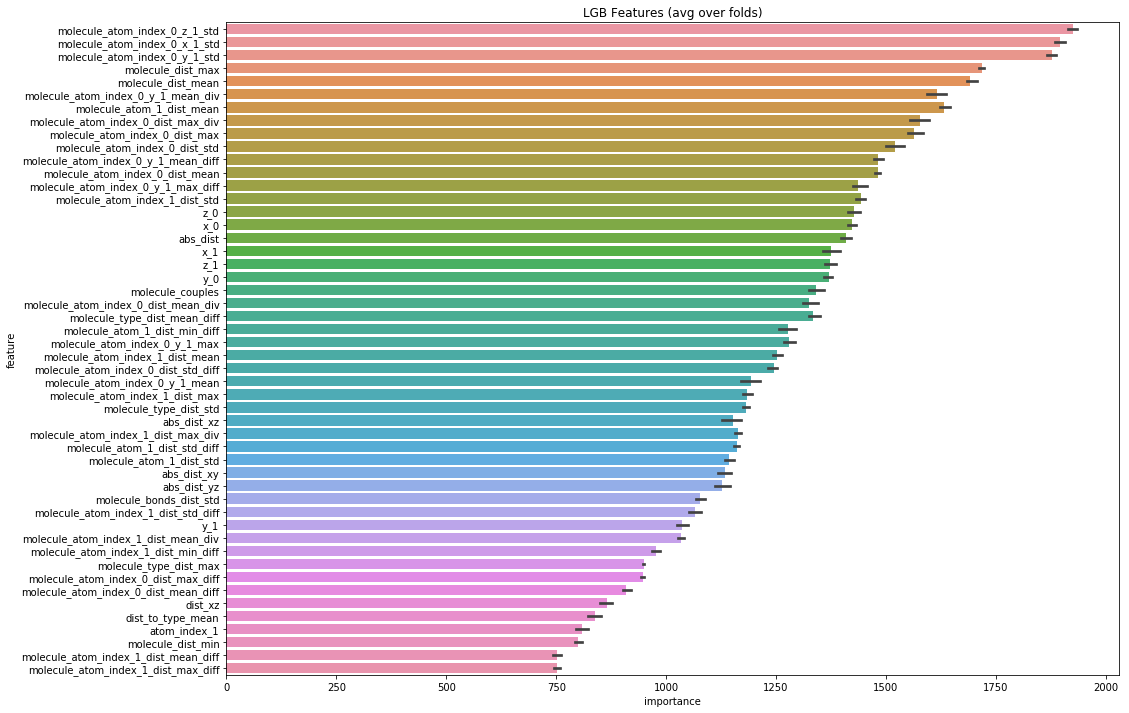

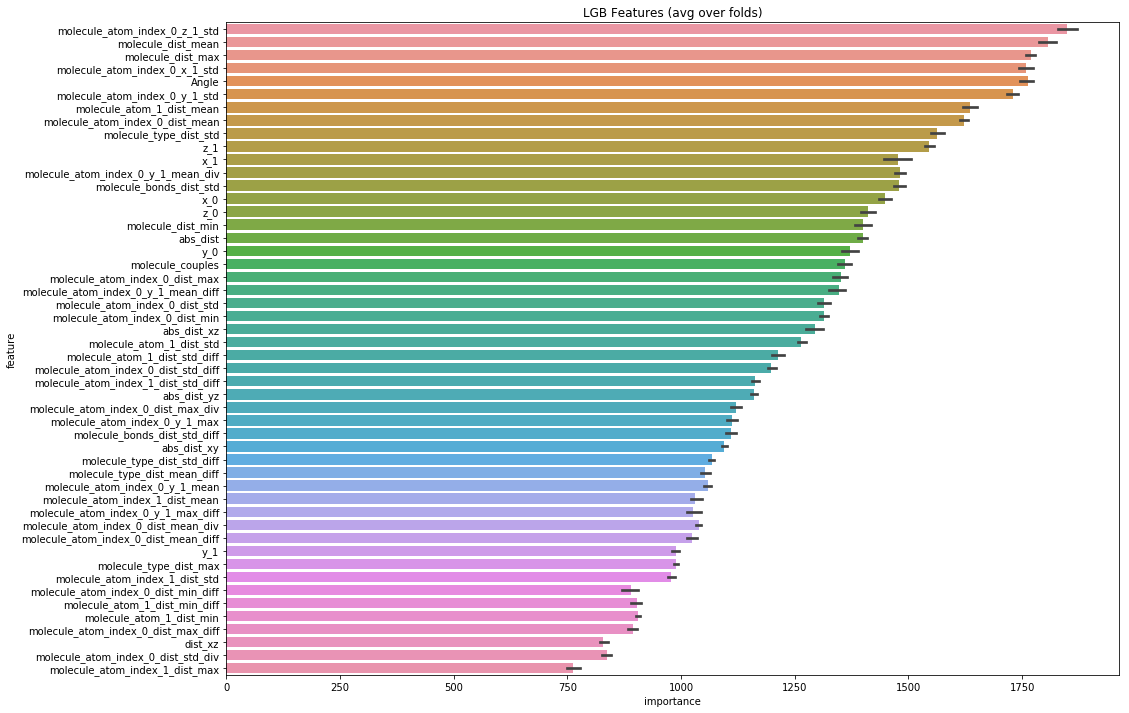

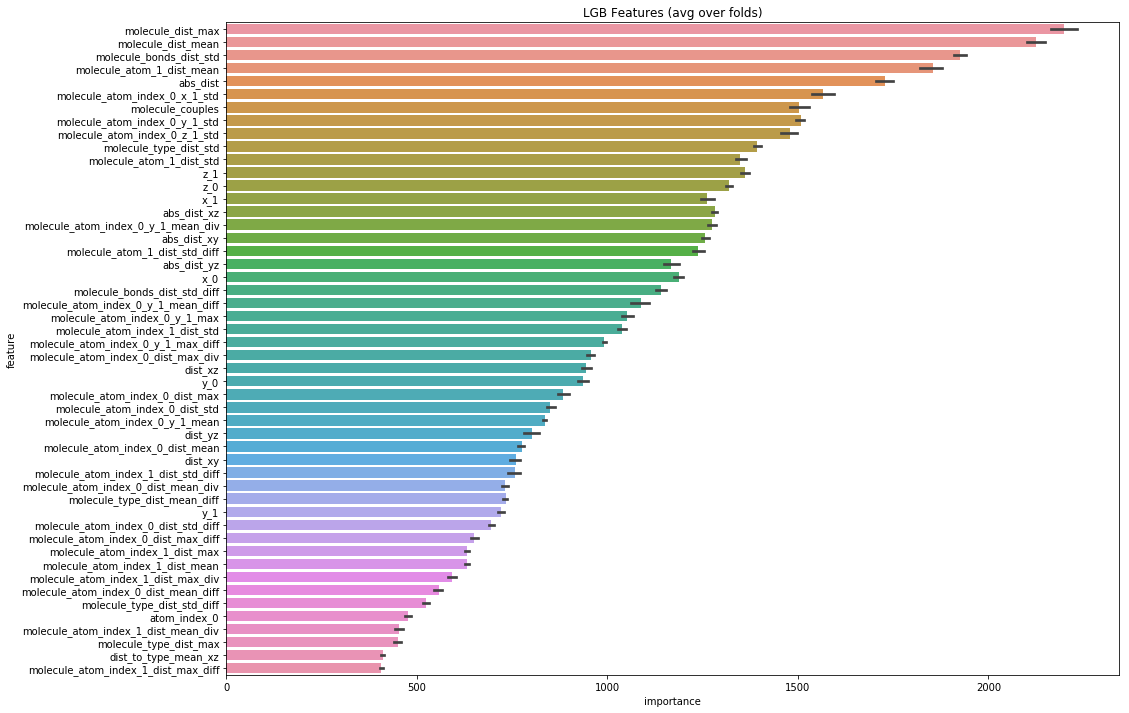

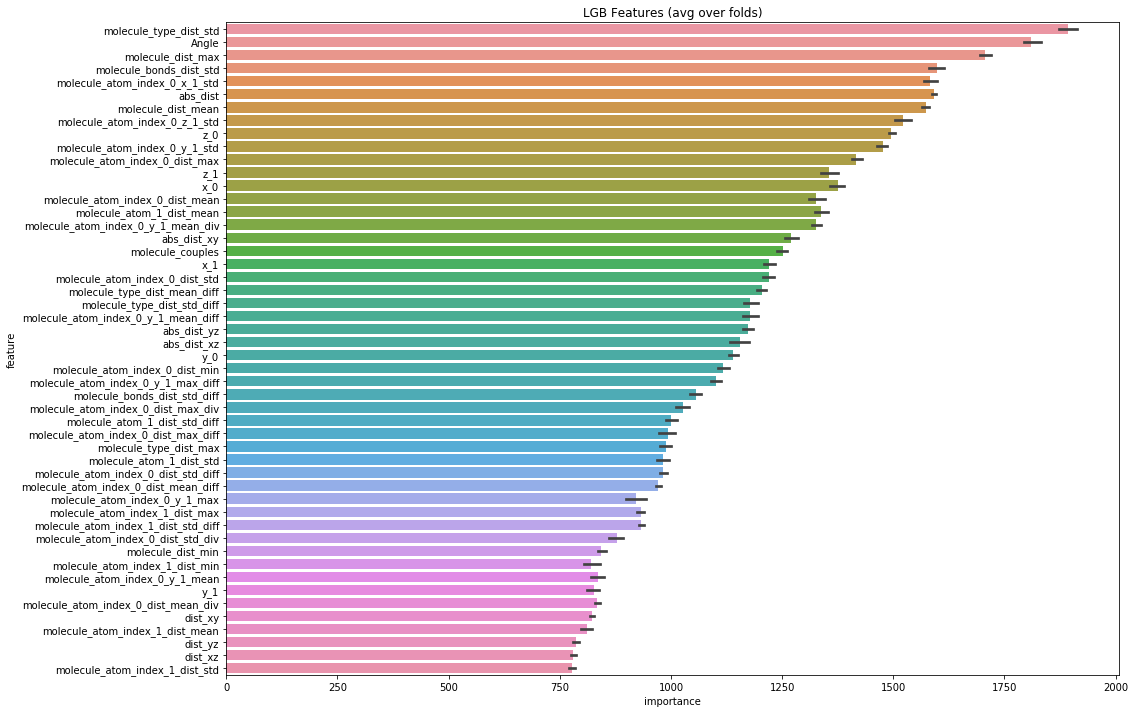

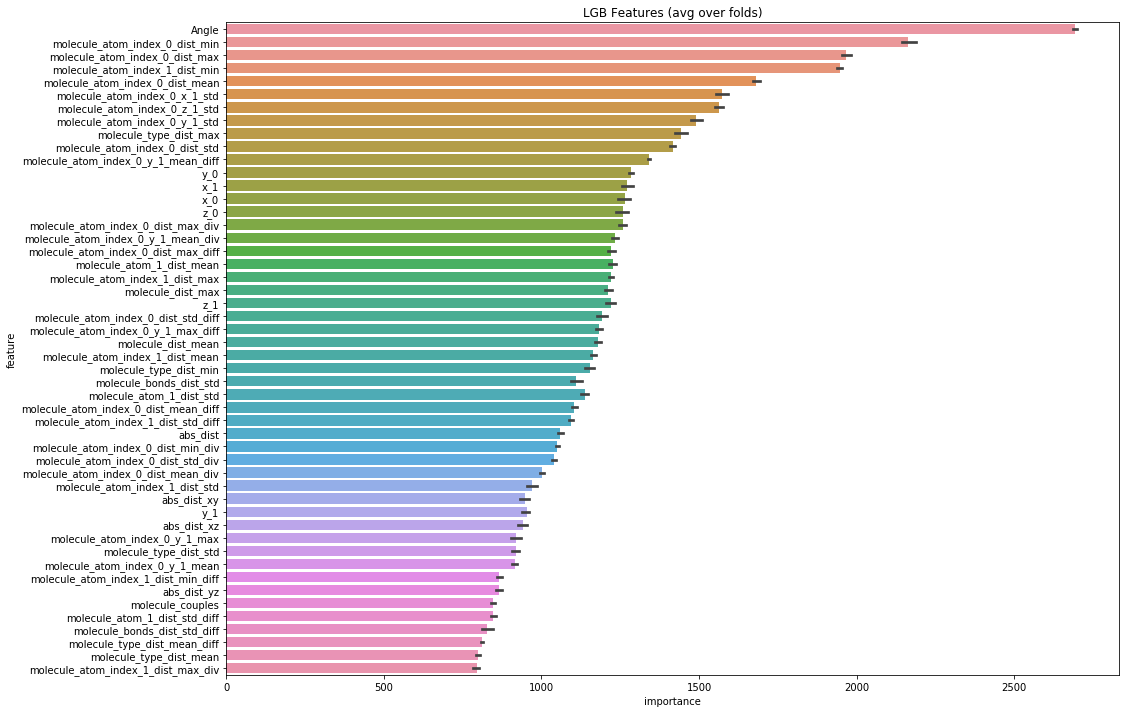

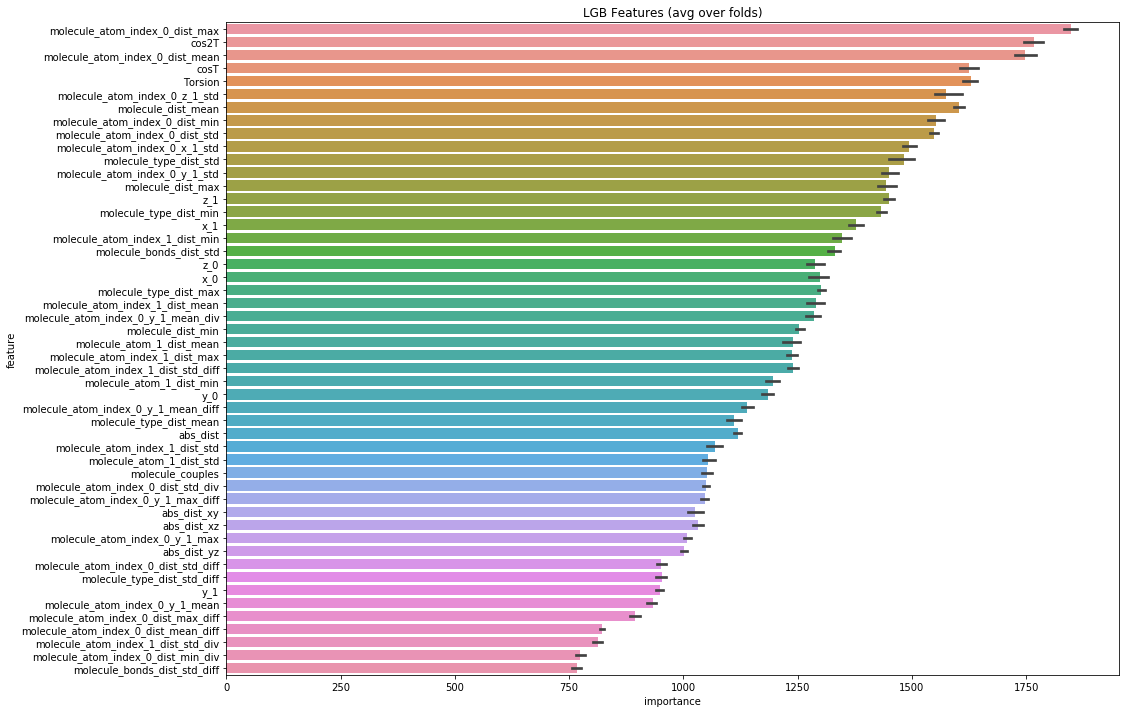

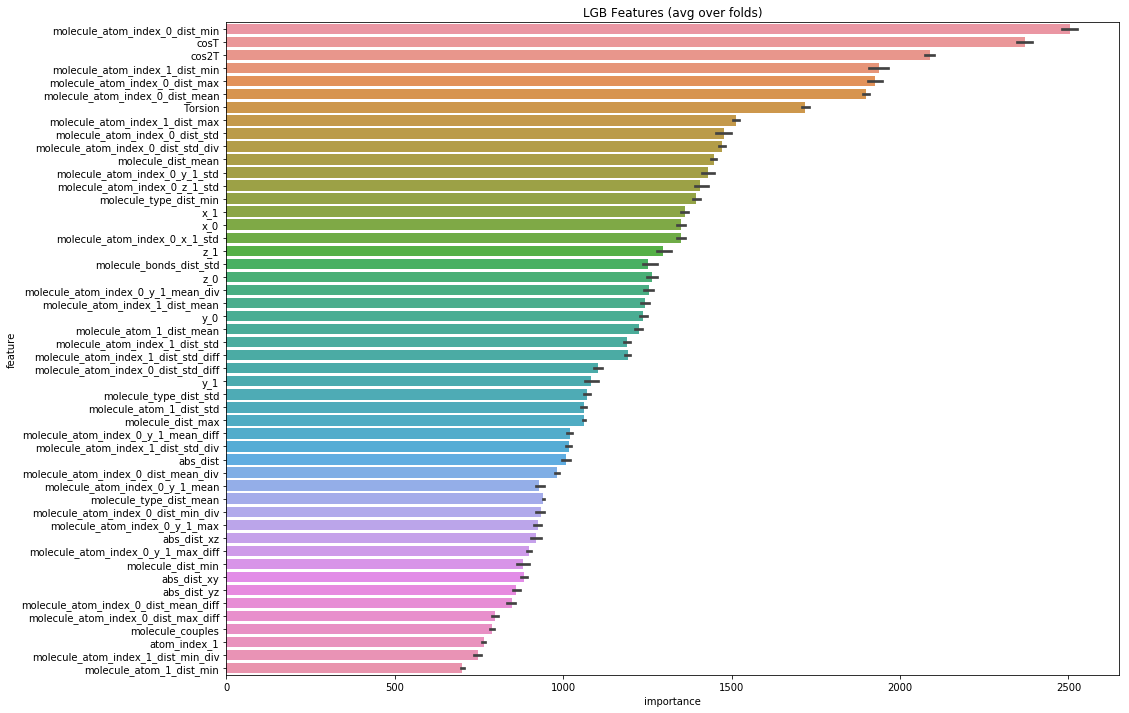

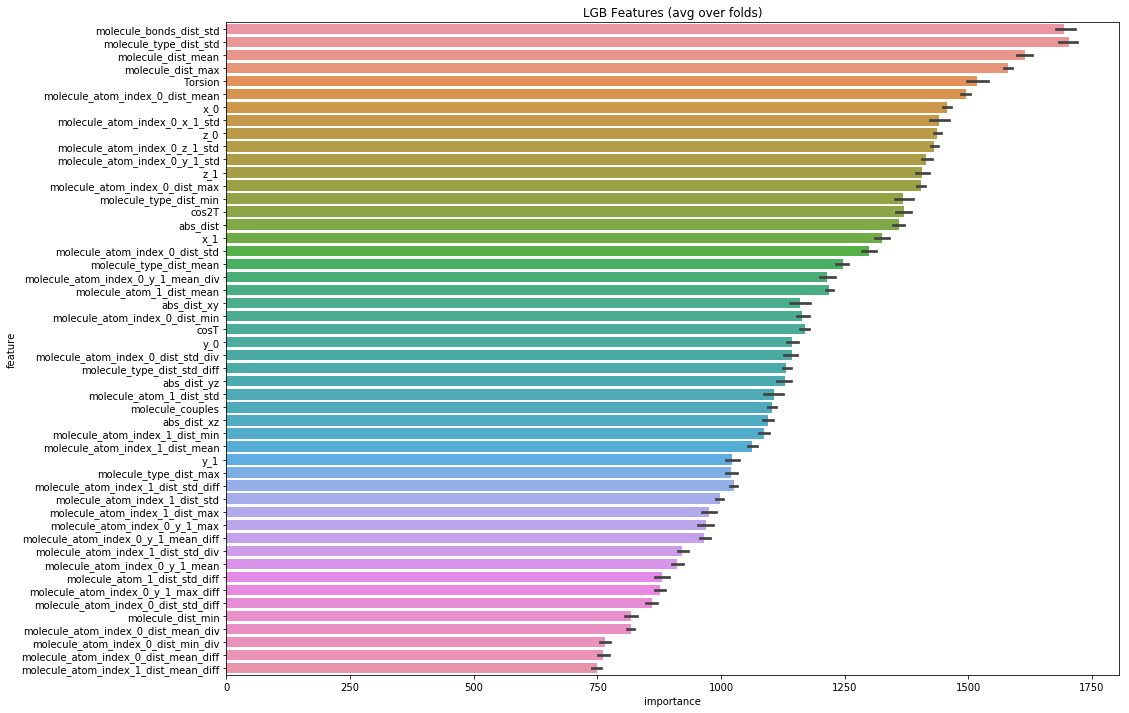

In [101]:
prediction_lgb=pd.DataFrame(test.shape[0],index=test['id'],columns=['scalar_coupling_constant'],dtype=float)
oof_lgb=pd.DataFrame(train.shape[0],index=train['id'],columns=['oof'],dtype=float)

for t in train['type'].unique():
    print(f'Training of type {t}')
    b=int(t[0]) # current bond for this type
    print('Predicting J=',b)
    X=train[train.type==t]
    if (b==1):
        X['sp']=X.apply(lambda row: Atoms(row.molecule_name, row.atom_index_0, row.atom_index_1)[2].GetHyb(),axis=1) # second atom is C or N for bond 1
    if (b==2):
        X['Angle']=X.apply(lambda row: Angle2J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
    if (b==3):
        X['Torsion']=X.apply(lambda row: Torsion3J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
        X['cosT']=np.cos(np.deg2rad(X['Torsion']))
        X['cos2T']=np.cos(2*np.deg2rad(X['Torsion']))
    y = X['scalar_coupling_constant']
    ids_train=X['id']
    X = X.drop(['id','type', 'molecule_name', 'scalar_coupling_constant','bonds'], axis=1)
    
    X_test = test[test.type==t]
    if (b==1): 
        X_test['sp']=X_test.apply(lambda row: Atoms(row.molecule_name, row.atom_index_0, row.atom_index_1)[2].GetHyb(),axis=1) # second atom is C or N for bond 1
    if (b==2):
        X_test['Angle']=X_test.apply(lambda row: Angle2J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
    if (b==3):
        X_test['Torsion']=X_test.apply(lambda row: Torsion3J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1)  
        X_test['cosT']=np.cos(np.deg2rad(X_test['Torsion']))
        X_test['cos2T']=np.cos(2*np.deg2rad(X_test['Torsion']))
    ids_test=X_test['id']    
    X_test=X_test.drop(['id', 'type', 'molecule_name','bonds'], axis=1)
    
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
    
    fold_oof_lgb, fold_prediction_lgb, feature_importance = train_model(X=X,X_test=X_test,y=y,params=params,folds=folds, model_type='lgb', plot_feature_importance=True)
    
    prediction_lgb.loc[ids_test,'scalar_coupling_constant']=fold_prediction_lgb
    oof_lgb.loc[ids_train,'oof']=fold_oof_lgb

In [102]:
sub=sub.drop(['scalar_coupling_constant'],axis=1).merge(prediction_lgb,on='id')
sub.to_csv('submission_4.csv', index=False)
sub.head()

,id,scalar_coupling_constant
0,4658147,8.513788232064540
1,4658148,184.357525506454238
2,4658149,1.357365929858084
3,4658150,178.221483959393311
4,4658151,5.779797632476755


In [103]:
X['oof_fc'] = fold_oof_lgb

In [107]:
X_test['oof_fc'] = fold_prediction_lgb

In [ ]:
prediction_lgb=pd.DataFrame(test.shape[0],index=test['id'],columns=['scalar_coupling_constant'],dtype=float)
oof_lgb=pd.DataFrame(train.shape[0],index=train['id'],columns=['oof'],dtype=float)

for t in train['type'].unique():
    print(f'Training of type {t}')
    b=int(t[0]) # current bond for this type
    print('Predicting J=',b)
    X=train[train.type==t]
    if (b==1):
        X['sp']=X.apply(lambda row: Atoms(row.molecule_name, row.atom_index_0, row.atom_index_1)[2].GetHyb(),axis=1) # second atom is C or N for bond 1
    if (b==2):
        X['Angle']=X.apply(lambda row: Angle2J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
    if (b==3):
        X['Torsion']=X.apply(lambda row: Torsion3J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
        X['cosT']=np.cos(np.deg2rad(X['Torsion']))
        X['cos2T']=np.cos(2*np.deg2rad(X['Torsion']))
    y = X['scalar_coupling_constant']
    ids_train=X['id']
    X = X.drop(['id','type', 'molecule_name', 'scalar_coupling_constant','bonds'], axis=1)
    
    X_test = test[test.type==t]
    if (b==1): 
        X_test['sp']=X_test.apply(lambda row: Atoms(row.molecule_name, row.atom_index_0, row.atom_index_1)[2].GetHyb(),axis=1) # second atom is C or N for bond 1
    if (b==2):
        X_test['Angle']=X_test.apply(lambda row: Angle2J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1) 
    if (b==3):
        X_test['Torsion']=X_test.apply(lambda row: Torsion3J(row.molecule_name , row.atom_index_0, row.atom_index_1),axis=1)  
        X_test['cosT']=np.cos(np.deg2rad(X_test['Torsion']))
        X_test['cos2T']=np.cos(2*np.deg2rad(X_test['Torsion']))
    ids_test=X_test['id']    
    X_test=X_test.drop(['id', 'type', 'molecule_name','bonds'], axis=1)
    
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
    
    fold_oof_lgb, fold_prediction_lgb, feature_importance = train_model(X=X,X_test=X_test,y=y,params=params,folds=folds, model_type='lgb', plot_feature_importance=True)
    
    prediction_lgb.loc[ids_test,'scalar_coupling_constant']=fold_prediction_lgb
    oof_lgb.loc[ids_train,'oof']=fold_oof_lgb

Training of type 1JHC
Predicting J= 1
(709416, 82) (380609, 82)
Fold 0 started at Fri Jun 21 13:23:26 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.55752	valid_1's l1: 1.83404
[1000]	training's l1: 1.2568	valid_1's l1: 1.70509
[1500]	training's l1: 1.06183	valid_1's l1: 1.64333
[2000]	training's l1: 0.913822	valid_1's l1: 1.60412
[2500]	training's l1: 0.798231	valid_1's l1: 1.5793
[3000]	training's l1: 0.702473	valid_1's l1: 1.56106
[3500]	training's l1: 0.62198	valid_1's l1: 1.54827
[4000]	training's l1: 0.553257	valid_1's l1: 1.53733
Did not meet early stopping. Best iteration is:
[4000]	training's l1: 0.553257	valid_1's l1: 1.53733
Fold 1 started at Fri Jun 21 13:26:40 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 1.55489	valid_1's l1: 1.82893
[1000]	training's l1: 1.25499	valid_1's l1: 1.69972
[1500]	training's l1: 1.05954	valid_1's l1: 1.63781
[2000]	training's l1: 0.912124	valid_1's l1: 1.5997